In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [29]:
N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
# score_full_data = pd.DataFrame(
#     cross_val_score(
#         br_estimator, X_full, y_full, scoring="neg_root_mean_squared_error", cv=N_SPLITS
#     ),
#     columns=["Full Data"],
# )

# Add a single missing value to each row
# Change to 10% here
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_root_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    KNeighborsRegressor(n_neighbors=15),
    DecisionTreeRegressor(max_features="sqrt", random_state=0),
    RandomForestRegressor(n_estimators=10, random_state=0)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator), br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_root_mean_squared_error", cv=N_SPLITS
    )

# scores = pd.concat(
#     [score_full_data, score_simple_imputer, score_iterative_imputer],
#     keys=["Original", "SimpleImputer", "IterativeImputer"],
#     axis=1,
# )

scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=["Simple", "ML"],
    axis=1,
)

C:\Users\mpaiva\Anaconda3\envs\r-tutorial\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\mpaiva\Anaconda3\envs\r-tutorial\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\mpaiva\Anaconda3\envs\r-tutorial\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\mpaiva\Anaconda3\envs\r-tutorial\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\mpaiva\Anaconda3\envs\r-tutorial\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\mpaiva\Anaconda3\envs\r-tutorial\lib\site-packages\

In [26]:
scores

Simple                            ML                        \
       mean    median KNeighborsRegressor DecisionTreeRegressor   
0 -0.762328 -0.772693           -0.769030             -0.734616   
1 -0.897800 -0.907536           -0.903888             -0.885145   
2 -0.874334 -0.873379           -0.879056             -0.870688   
3 -1.148671 -1.132217           -1.153222             -1.096088   
4 -0.814357 -0.835701           -0.814117             -0.746230   

                                             
  ExtraTreesRegressor RandomForestRegressor  
0           -0.688062             -0.691568  
1           -0.834592             -0.838835  
2           -0.813027             -0.834138  
3           -1.093765             -1.086570  
4           -0.679121             -0.683747

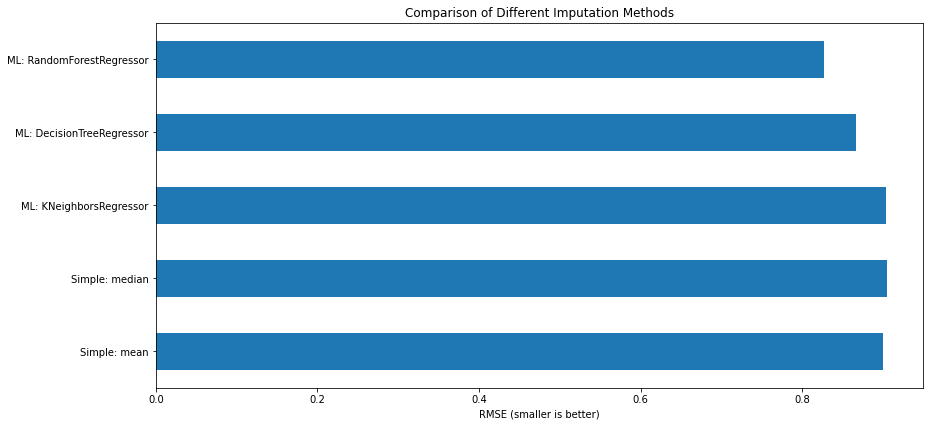

In [30]:
# plot results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
# errors = scores.std()
# means.plot.barh(xerr=errors, ax=ax)
means.plot.barh(ax=ax)
ax.set_title("Comparison of Different Imputation Methods")
ax.set_xlabel("RMSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([": ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

In [15]:
means

SimpleImputer     mean                     0.899498
                  median                   0.904305
IterativeImputer  BayesianRidge            0.829187
                  DecisionTreeRegressor    0.866554
                  ExtraTreesRegressor      0.821713
                  KNeighborsRegressor      0.903863
dtype: float64

In [6]:
pd.DataFrame(X_full)

,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,3.2031,52.0,5.477612,1.079602,910.0,2.263682,37.85,-122.26
2,1.3578,40.0,4.524096,1.108434,409.0,2.463855,37.85,-122.27
3,1.9274,49.0,5.068783,1.182540,863.0,2.283069,37.84,-122.28
4,2.0978,52.0,4.215190,1.060759,946.0,2.394937,37.83,-122.26
...,...,...,...,...,...,...,...,...
2059,1.6840,41.0,4.226629,0.991501,804.0,2.277620,39.14,-121.59
2060,3.1029,18.0,4.945455,1.112121,769.0,2.330303,39.16,-121.57
2061,1.3631,28.0,4.851936,1.102506,1195.0,2.722096,39.10,-121.56
2062,4.5625,40.0,4.125000,0.854167,151.0,3.145833,39.05,-121.48


In [8]:
pd.DataFrame(y_full)

,0
0,4.526
1,2.815
2,1.475
3,1.223
4,1.554
...,...
2059,0.713
2060,0.717
2061,0.455
2062,1.000


In [11]:
pd.DataFrame(y_full[::10])

,0
0,4.526
1,2.578
2,0.808
3,0.895
4,2.613
...,...
202,2.146
203,1.854
204,2.414
205,2.270
